In [1]:
%matplotlib inline

import random
import math
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
random.seed(1)

In [5]:
# Select bandit type --OPTIONS {'bernoulli', 'normal'}
bandit_type = 'bernoulli' 
num_sims= 5000 # Number of simulation
horizon = 250 # The number of times the algorithm has been able to pull on any of the arms that are available.

In [6]:
import random

def ind_max(x):
    max_value = max(x) # obtain max value from list
    max_keys = [k for k, v in enumerate(x) if v == max_value]
    return random.choice(max_keys)


class ThompsonSampling():
    def __init__(self, initial_alpha, initial_beta, counts, values, s_counts):
        self.counts = counts
        self.s_counts = s_counts
        self.values = values
        self.alpha = initial_alpha
        self.beta = initial_beta
        return

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        self.s_counts = [0 for col in range(n_arms)]
        return

    def select_arm(self):
        rho = lambda i: random.betavariate(self.alpha + self.s_counts[i], self.beta + self.counts[i] - self.s_counts[i])
        temp = len(self.counts)
        mu = [rho(i) for i in range(temp)]
        #mu = map(rho, list(range(temp)))
        return ind_max(mu)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        if reward == 1:
            self.s_counts[chosen_arm] += 1

        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return


In [7]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0
        



class NormalArm():
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
  
    def draw(self):
        return random.gauss(self.mu, self.sigma)

  


In [8]:
def test_algorithm(algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]
  
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
    
        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1
            sim_nums[index] = sim
            times[index] = t
            
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            reward = arms[chosen_arms[index]].draw()
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward
      
            algo.update(chosen_arm, reward)

    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]



In [20]:
def simulate_tests_bernoulli(means=[0.7, 0.2],
                   filename="bern_thompson_sampling_results.csv",
                   num_sims= num_sims, horizon=horizon):

    
    n_arms = len(means)
    arms = [BernoulliArm(mu) for mu in means]
    best_arm = ind_max(means)
    
    print("Best arm is at index " + str(ind_max(means)))

    f = open(filename, "w")

    algo = ThompsonSampling(1,1, [], [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, num_sims, horizon)
    
    
    
    for i in range(len(results[0])):
        f.write(",".join([str(results[j][i]) for j in range(len(results))]) + "\n")

    f.close()
    # Read this 
    file_location = './' + filename
    df = pd.read_csv(filename, header=None, 
                     names=["Sim", "T", "ChosenArm", "Reward", "CumulativeReward"])
    
    return df, best_arm

In [10]:
def simulate_tests_normal(means = [250, 290],
                          sigmas=[70, 90],
                          filename="normal_thompson_sampling_results.csv",
                          num_sims= num_sims, horizon=horizon):


    n_arms = len(means)
    
    hyp = list(zip(means, sigmas))
    arms = [NormalArm(mu, sig) for mu in means for sig in sigmas]
    best_arm = ind_max(means)
    
    print("Best arm is at index " + str(ind_max(means)))

    f = open(filename, "w")

    algo = ThompsonSampling(1, 1, [], [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, num_sims, horizon)
    
    
    for i in range(len(results[0])):
        f.write(",".join([str(results[j][i]) for j in range(len(results))]) + "\n")

    f.close()
    
    # Read this 
    file_location = './' + filename
    df = pd.read_csv(filename, header=None, 
                     names=["Sim", "T", "ChosenArm", "Reward", "CumulativeReward"])
    
    return df, best_arm

# Performance evaluation

## Probability of choosing best arm over time

In [11]:
def plot_prob_best_arm(df, best_arm):
    df = df.copy()
    xseries = df[df['ChosenArm']==best_arm].groupby(['T'])['ChosenArm'].count().to_frame()
    xseries['ChosenArm'] = xseries['ChosenArm']/num_sims
    xseries.plot(ylabel='Probability of selecting best arm', xlabel='Time', figsize=(15,8))
    plt.show()


## Average reward over time

In [17]:
def plot_avg_reward(df):
    df = df.copy()
    plt.figure(figsize=(15,8))
    xseries = df.groupby(['T'])['Reward'].mean()
    xseries.plot()
    plt.ylabel("Average reward")
    plt.title("Plot of average reward across " + str(num_sims) + " simulations")
    plt.xlabel("Time")
    plt.show()

## Cumulative reward over time

In [14]:
def plot_cumulative_reward(df):
    """ total amount of reward that the algorithm has won for us up until some fixed point in time. """
    df = df.copy()
    plt.figure(figsize=(15,8))
    xseries = df.groupby(['T'])['CumulativeReward'].mean()
    xseries.plot()
    plt.title("Plot of cumulative reward over time")
    plt.ylabel("Cumulative reward")
    plt.xlabel("Time")
    plt.show()

# Example

With only two arms

In [15]:
if bandit_type == 'normal':
    df, best_arm = simulate_tests_normal()
    plot_prob_best_arm(df, best_arm)
    plot_avg_reward(df)
    plot_cumulative_reward(df)

Best arm is at index 0


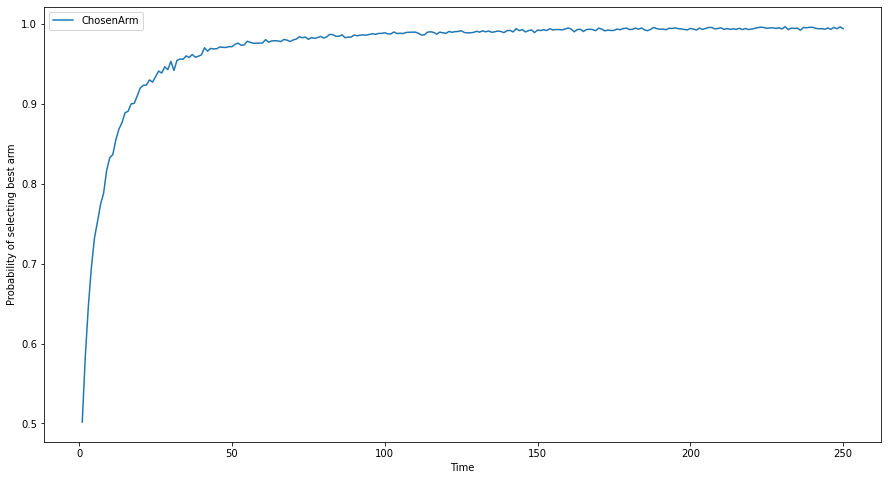

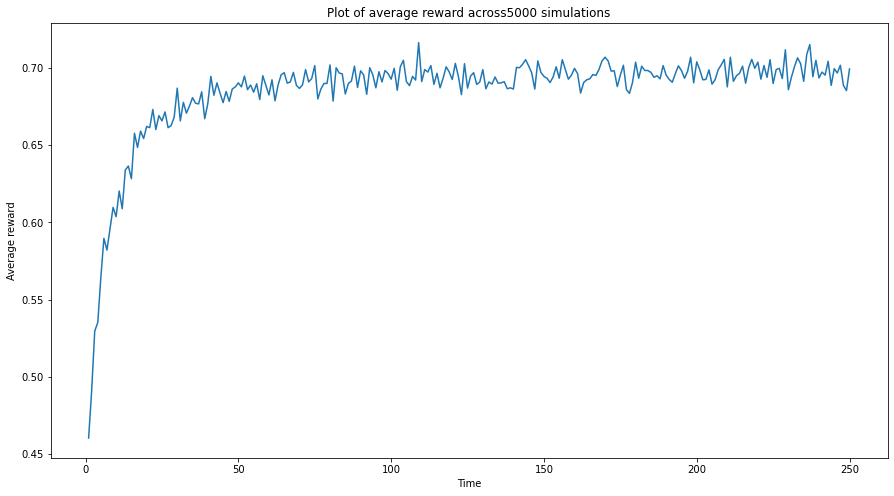

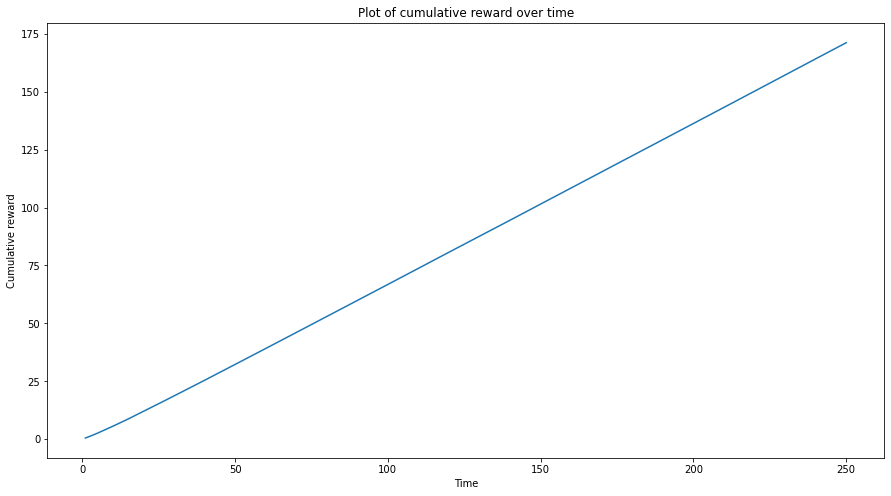

In [21]:
if bandit_type == 'bernoulli':
    df, best_arm = simulate_tests_bernoulli()
    plot_prob_best_arm(df, best_arm)
    plot_avg_reward(df)
    plot_cumulative_reward(df)

In [22]:
df

,Sim,T,ChosenArm,Reward,CumulativeReward
0,1,1,1,0.0,0.0
1,1,2,1,1.0,1.0
2,1,3,1,1.0,2.0
3,1,4,0,1.0,3.0
4,1,5,0,1.0,4.0
...,...,...,...,...,...
1249995,5000,246,0,1.0,160.0
1249996,5000,247,0,0.0,160.0
1249997,5000,248,0,1.0,161.0
1249998,5000,249,0,1.0,162.0
